In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-07-23 23:58:20.980375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 23:58:20.980482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 23:58:21.121222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/breast-ultrasound-images-dataset...,benign
1,/kaggle/input/breast-ultrasound-images-dataset...,benign
2,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,benign
4,/kaggle/input/breast-ultrasound-images-dataset...,benign
...,...,...
1573,/kaggle/input/breast-ultrasound-images-dataset...,malignant
1574,/kaggle/input/breast-ultrasound-images-dataset...,malignant
1575,/kaggle/input/breast-ultrasound-images-dataset...,malignant
1576,/kaggle/input/breast-ultrasound-images-dataset...,malignant


In [4]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [5]:
test_df

,filepaths,labels
1024,/kaggle/input/breast-ultrasound-images-dataset...,normal
215,/kaggle/input/breast-ultrasound-images-dataset...,benign
106,/kaggle/input/breast-ultrasound-images-dataset...,benign
339,/kaggle/input/breast-ultrasound-images-dataset...,benign
305,/kaggle/input/breast-ultrasound-images-dataset...,benign
...,...,...
1444,/kaggle/input/breast-ultrasound-images-dataset...,malignant
1413,/kaggle/input/breast-ultrasound-images-dataset...,malignant
460,/kaggle/input/breast-ultrasound-images-dataset...,benign
1109,/kaggle/input/breast-ultrasound-images-dataset...,normal


In [6]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.


In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/50


I0000 00:00:1721779265.835629      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721779265.995720      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5394 - loss: 12.3137

W0000 00:00:1721779383.866621      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/158 ━━━━━━━━━━━━━━━━━━━━ 276s 824ms/step - accuracy: 0.5398 - loss: 12.2998 - val_accuracy: 0.7911 - val_loss: 7.9660
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.6737 - loss: 6.8552 - val_accuracy: 0.6899 - val_loss: 6.2893
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6989 - loss: 5.7615 - val_accuracy: 0.6804 - val_loss: 5.2916
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.7131 - loss: 4.9324 - val_accuracy: 0.7722 - val_loss: 4.2678
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.7091 - loss: 4.1844 - val_accuracy: 0.8323 - val_loss: 3.6322
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7571 - loss: 3.5603 - val_accuracy: 0.8386 - val_loss: 3.1063
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8135 - loss: 2.9639 - val_accuracy: 0.8386 - val_loss: 2.6109
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8093 - loss: 2.5274 - v

In [9]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9968 - loss: 0.2405
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9209 - loss: 0.3966
Train Loss:  0.25167596340179443
Train Accuracy:  0.996038019657135
--------------------
Test Loss:  0.38626983761787415
Test Accuracy:  0.9367088675498962


In [10]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

W0000 00:00:1721780240.682151      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step


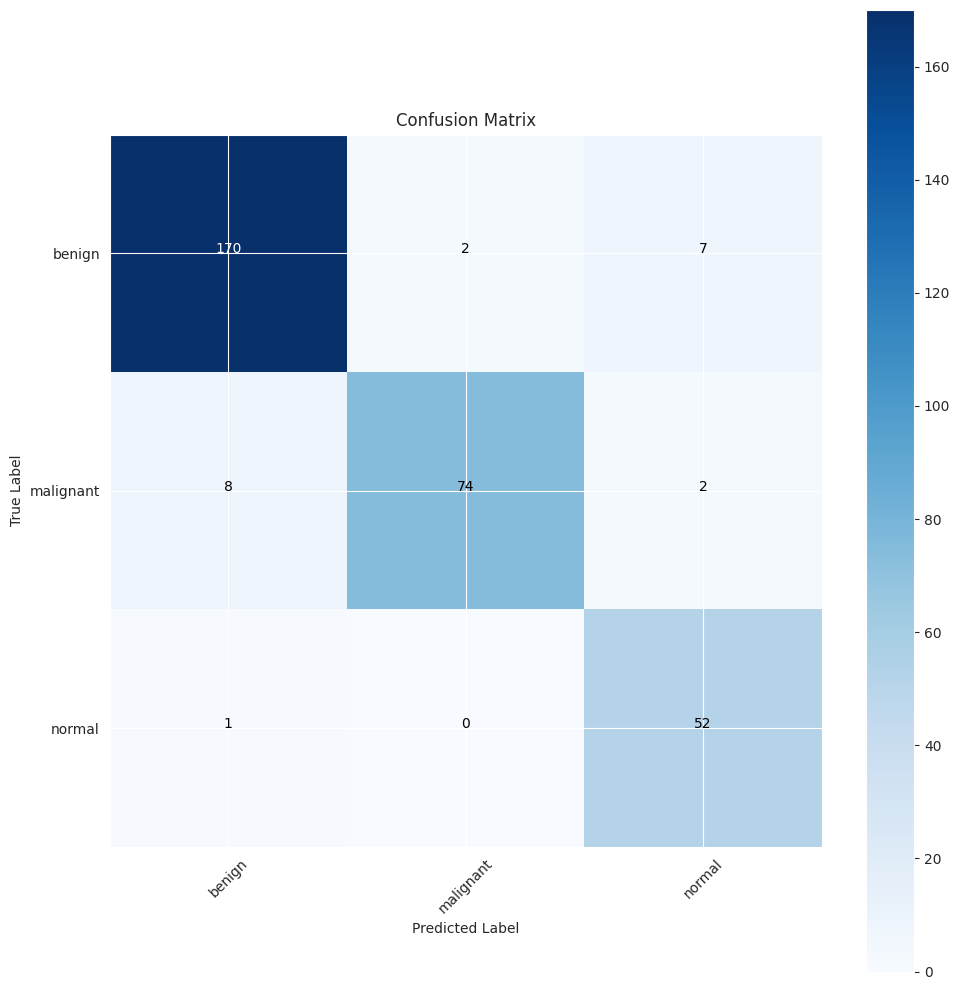

In [11]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [12]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.95      0.95      0.95       179
   malignant       0.97      0.88      0.93        84
      normal       0.85      0.98      0.91        53

    accuracy                           0.94       316
   macro avg       0.93      0.94      0.93       316
weighted avg       0.94      0.94      0.94       316



In [13]:
#Save the model
model.save('Model.h5')